In [1]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U transformers ftfy gradio accelerate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 22.0 

In [3]:
!pip install git+https://github.com/huggingface/diffusers

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-cviupkjh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-cviupkjh
  Resolved https://github.com/huggingface/diffusers to commit 6be43bd855772f5ffb064bc7c6049f578b3856f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.29.0.dev0-py3-none-any.whl size=2175553 sha256=eed53d1fd5076c6421dc5ce5b1428d65007b45a94c9735b9c1cdd3e052495dde
  Stored in directory: /tmp/pip-ephem-wheel-cache-vnwar1br/wheels/f7/7d/99/d361489e5762e3464b3811bc629e94cf5bf5ef44dd5c3c4d52
Successfully built diffusers


In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/research_projects/dreambooth_inpaint/train_dreambooth_inpaint.py

--2024-05-22 20:01:00--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/research_projects/dreambooth_inpaint/train_dreambooth_inpaint.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33292 (33K) [text/plain]
Saving to: ‘train_dreambooth_inpaint.py’

train_dreambooth_in 100%[===================>]  32.51K  --.-KB/s    in 0.01s   

2024-05-22 20:01:00 (3.09 MB/s) - ‘train_dreambooth_inpaint.py’ saved [33292/33292]



In [4]:
import inspect
from typing import List, Optional, Union
import numpy as np
import torch
import os
import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline
import requests
from io import BytesIO
from PIL import Image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [10]:
def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = PIL.Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [ ]:
# test vanilla stable diffusion inpainting with empty mask
device = "cuda"
model_path = "stabilityai/stable-diffusion-2-inpainting"

vanilla_sd = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
prompt = "POV, walkthrough, castle from Frozen, masterpiece, indoor scene"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(1) # change the seed to get different results

empty_mask = Image.open("/content/drive/MyDrive/cs231n_final_project/empty_mask.png").convert("RGB")
images = vanilla_sd(
    prompt=prompt,
    image=empty_mask,
    mask_image=empty_mask, # entire image unmasked
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

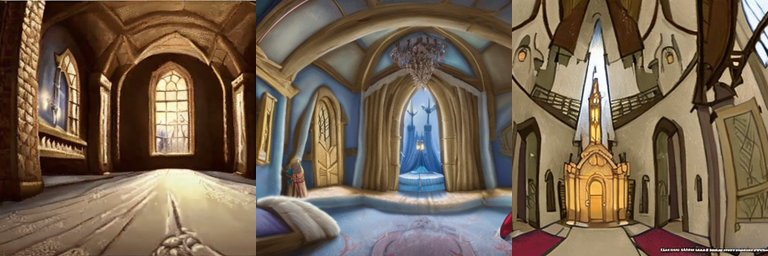

In [ ]:
image_grid(images, 1, num_samples)

In [ ]:
prompt = "POV, walkthrough, train from Studio Ghibli's Spirited Away, masterpiece, indoor scene"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(1) # change the seed to get different results

empty_mask = Image.open("/content/drive/MyDrive/cs231n_final_project/empty_mask.png").convert("RGB")
images = vanilla_sd(
    prompt=prompt,
    image=empty_mask,
    mask_image=empty_mask, # entire image unmasked
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

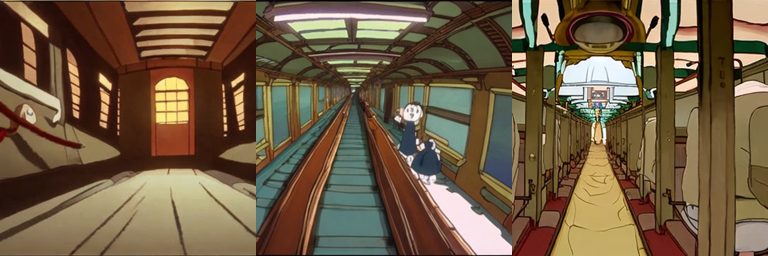

In [ ]:
image_grid(images, 1, num_samples)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

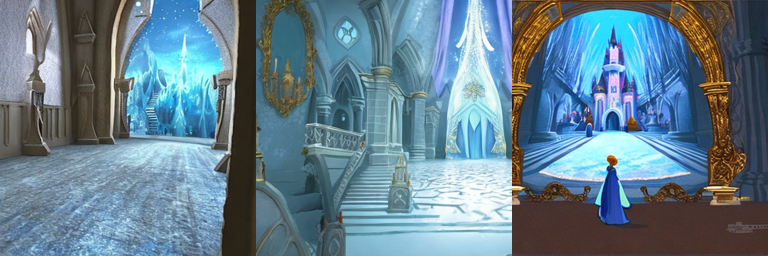

In [ ]:
# test vanilla stable diffusion non-inpainting with empty mask
device = "cuda"
model_path = "stabilityai/stable-diffusion-2-1-base"

vanilla_sd_noninpaint = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

prompt = "POV, walkthrough, castle from Frozen, masterpiece, indoor scene"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

empty_mask = Image.open("/content/drive/MyDrive/cs231n_final_project/empty_mask.png").convert("RGB")
images = vanilla_sd_noninpaint(
    prompt=prompt,
    image=empty_mask,
    mask_image=empty_mask, # entire image unmasked
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

image_grid(images, 1, num_samples)

In [ ]:
local_dir = "/content/drive/MyDrive/cs231n_final_project/"

In [ ]:
!pip install torch

In [4]:
%cd /content/drive/MyDrive/cs231n_final_project/

/content/drive/MyDrive/cs231n_final_project


In [ ]:
!accelerate config

----------------------------------------------------------------------------------------------------In which compute environment are you running?
Please input a choice index (starting from 0), and press enter
 ➔  This machine
    AWS (Amazon SageMaker)

This machine
----------------------------------------------------------------------------------------------------Which type of machine are you using?
Please input a choice index (starting from 0), and press enter
 ➔  No distributed training
    multi-CPU
    multi-XPU
    multi-GPU
    multi-NPU
    multi-MLU
    TPU

No distributed training
Do you want to run your training on CPU only (even if a GPU / Apple Silicon / Ascend NPU device is available)? [yes/NO]:NO
Do you wish to optimize your script with torch dynamo?[yes/NO]:
Do you want to use DeepSpeed? [yes/NO]: 
What GPU(s) (by id) should be used for training on this machine as a comma-seperated list? [all]:
Would you like to enable numa efficiency? (Currently only supported on NVIDI

In [5]:
from huggingface_hub import notebook_login
notebook_login()

# FROZEN

## dreambooth on stable diffusion 2.1, non-inpaint

In [ ]:
# finetune text encoder too
from pathlib import Path

!accelerate launch train_dreambooth.py \
    --train_text_encoder \
    --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1-base"  \
    --instance_data_dir="frozen/data" \
    --output_dir="frozen/frozen-stable-diffusion-non-inpaint" \
    --instance_prompt="a photo of sks frozen" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1 \
    --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


Streaming output truncated to the last 5000 lines.
optimizer.bin:  25% 2.43G/9.65G [01:32<03:03, 39.3MB/s]




diffusion_pytorch_model.safetensors:  82% 2.83G/3.46G [01:33<00:20, 30.9MB/s]

diffusion_pytorch_model.safetensors:  72% 2.48G/3.46G [01:33<00:36, 26.9MB/s]




diffusion_pytorch_model.safetensors:  82% 2.84G/3.46G [01:33<00:13, 44.7MB/s]

diffusion_pytorch_model.safetensors:  72% 2.49G/3.46G [01:33<00:27, 35.8MB/s]





optimizer.bin:  25% 2.43G/9.65G [01:33<03:40, 32.8MB/s]

diffusion_pytorch_model.safetensors:  72% 2.50G/3.46G [01:33<00:23, 40.6MB/s]





optimizer.bin:  25% 2.44G/9.65G [01:33<03:05, 38.9MB/s]




diffusion_pytorch_model.safetensors:  82% 2.85G/3.46G [01:33<00:16, 36.9MB/s]





optimizer.bin:  25% 2.45G/9.65G [01:33<02:32, 47.2MB/s]




diffusion_pytorch_model.safetensors:  83% 2.86G/3.46G [01:33<00:13, 44.3MB/s]

diffusion_pytorch_model.safetensors:  72% 2.50G/3.46G [01:34<00:28, 33.6MB/s]

diffusion_pytorch_model.safetensors:  72% 2.51G/3.46G [01:34<00:2

In [ ]:
device = "cuda"
model_path = "emily49/frozen-stable-diffusion-non-inpaint"

finetuned_sd = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/780 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
prompt = "POV, walkthrough, castle from sks frozen, masterpiece, indoor scene"

guidance_scale=7.5
num_samples = 6
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

empty_mask = Image.open("/content/drive/MyDrive/cs231n_final_project/empty_mask.png").convert("RGB")
images = finetuned_sd(
    prompt=prompt,
    image=empty_mask,
    mask_image=empty_mask, # entire image unmasked
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

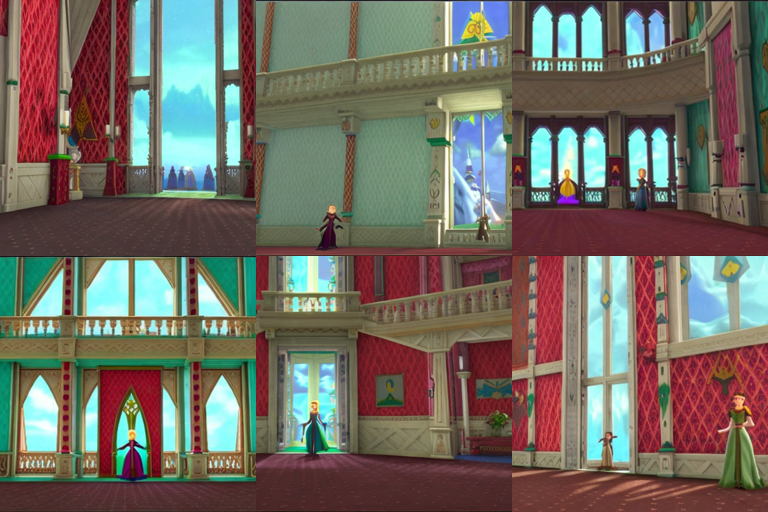

In [ ]:
image_grid(images, 2, 3)

# dreambooth on stable diffusion 1.5, non inpaint. for testing with control net

In [17]:
# finetune text encoder too
from pathlib import Path

!accelerate launch train_dreambooth.py \
    --train_text_encoder \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
    --instance_data_dir="frozen/data" \
    --output_dir="frozen/frozen-stable-diffusion-non-inpaint-1-5" \
    --instance_prompt="a photo of sks frozen" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1 \
    --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


Streaming output truncated to the last 5000 lines.

optimizer.bin:  15% 1.17G/7.86G [00:42<03:39, 30.4MB/s]




optimizer.bin:  15% 1.17G/7.86G [00:42<03:04, 36.2MB/s]


diffusion_pytorch_model.safetensors:  38% 1.32G/3.44G [00:42<00:57, 36.8MB/s]


diffusion_pytorch_model.safetensors:  39% 1.33G/3.44G [00:42<00:42, 49.4MB/s]

diffusion_pytorch_model.safetensors:  34% 1.15G/3.44G [00:42<01:12, 31.6MB/s]




optimizer.bin:  15% 1.18G/7.86G [00:43<03:27, 32.2MB/s]

diffusion_pytorch_model.safetensors:  34% 1.16G/3.44G [00:42<00:50, 45.4MB/s]


diffusion_pytorch_model.safetensors:  39% 1.33G/3.44G [00:42<00:53, 39.2MB/s]


diffusion_pytorch_model.safetensors:  39% 1.34G/3.44G [00:42<00:39, 52.9MB/s]




optimizer.bin:  15% 1.18G/7.86G [00:43<04:47, 23.3MB/s]

diffusion_pytorch_model.safetensors:  34% 1.17G/3.44G [00:43<01:15, 30.0MB/s]




optimizer.bin:  15% 1.20G/7.86G [00:43<03:08, 35.3MB/s]

diffusion_pytorch_model.safetensors:  34% 1.18G/3.44G [00:43<01:03, 35.8MB/s]


diffusion_pyto

# dreambooth on stable diffusion 2, inpaint. tested with 3d pipeline, didn't work well

In [ ]:
# finetune an inpainting version too

from pathlib import Path

!accelerate launch train_dreambooth_inpaint.py \
    --train_text_encoder \
    --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-inpainting"  \
    --instance_data_dir="frozen/data" \
    --output_dir="frozen/frozen-stable-diffusion-inpaint" \
    --instance_prompt="a photo of sks frozen" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1 \
    --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


Streaming output truncated to the last 5000 lines.




diffusion_pytorch_model.safetensors:  54% 1.87G/3.46G [01:30<01:11, 22.4MB/s]

optimizer.bin:  20% 1.94G/9.65G [01:29<05:32, 23.2MB/s]


diffusion_pytorch_model.safetensors:  42% 1.47G/3.46G [01:29<01:05, 30.7MB/s]

optimizer.bin:  20% 1.94G/9.65G [01:29<04:53, 26.3MB/s]




diffusion_pytorch_model.safetensors:  54% 1.88G/3.46G [01:30<01:01, 25.8MB/s]


diffusion_pytorch_model.safetensors:  42% 1.47G/3.46G [01:29<01:05, 30.6MB/s]

optimizer.bin:  20% 1.94G/9.65G [01:29<04:37, 27.8MB/s]




diffusion_pytorch_model.safetensors:  54% 1.88G/3.46G [01:30<00:57, 27.6MB/s]

optimizer.bin:  20% 1.95G/9.65G [01:29<04:27, 28.8MB/s]


diffusion_pytorch_model.safetensors:  43% 1.47G/3.46G [01:29<01:31, 21.7MB/s]




diffusion_pytorch_model.safetensors:  55% 1.89G/3.46G [01:30<01:09, 22.5MB/s]


diffusion_pytorch_model.safetensors:  43% 1.48G/3.46G [01:29<01:08, 29.0MB/s]

optimizer.bin:  20% 1.95G/9.65G [01:30<05:26, 23.6MB/s]

optimizer.bin: 

In [ ]:
device = "cuda"
model_path = "emily49/frozen-stable-diffusion-inpaint"

# finetuned_sd = StableDiffusionInpaintPipeline.from_pretrained(
#     model_path,
#     torch_dtype=torch.float16,
# ).to(device)

# prompt = "POV, walkthrough, castle from sks frozen, masterpiece, indoor scene"

# guidance_scale=7.5
# num_samples = 6
# generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

empty_mask = Image.open("/content/drive/MyDrive/cs231n_final_project/empty_mask.png").convert("RGB")
images = finetuned_sd(
    prompt=prompt,
    image=empty_mask,
    mask_image=empty_mask, # entire image unmasked
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
    height=600,
    width=600,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

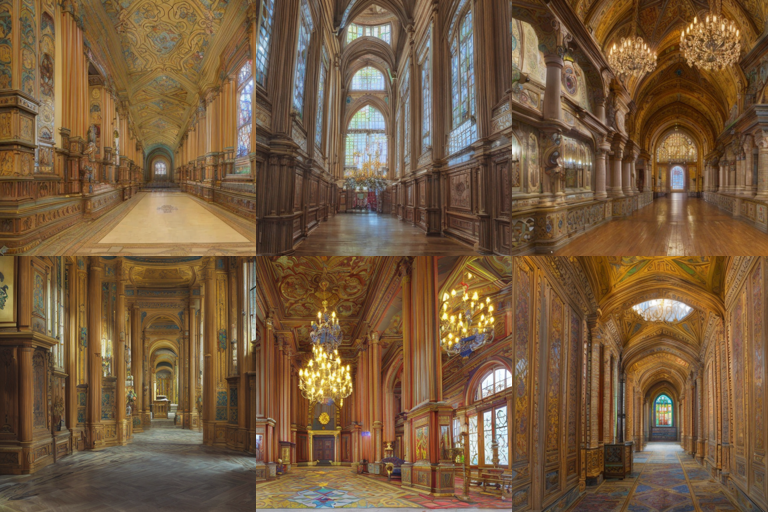

In [ ]:
image_grid(images, 2, 3)

# SPIRITED AWAY

In [ ]:
# no train text encoder
from pathlib import Path

!accelerate launch train_dreambooth.py \
    --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1-base"  \
    --instance_data_dir="spirited_away/data" \
    --output_dir="spirited_away/spirited-away-stable-diffusion-non-inpaint-non-text" \
    --instance_prompt="a photo of sks spiritedaway" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1
    # --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-05-23 02:20:01.050405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 02:20:01.050453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 02:20:01.052253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

In [ ]:
device = "cuda"
model_path = "spirited_away/spirited-away-stable-diffusion-non-inpaint-non-text"

finetuned_sd_non_text = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
prompt = "POV, walkthrough, train from sks spiritedaway, masterpiece, indoor scene"

guidance_scale=7.5
num_samples = 6
generator = torch.Generator(device="cuda").manual_seed(1) # change the seed to get different results

empty_mask = Image.open("/content/drive/MyDrive/cs231n_final_project/empty_mask.png").convert("RGB")
images = finetuned_sd_non_text(
    prompt=prompt,
    image=empty_mask,
    mask_image=empty_mask, # entire image unmasked
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

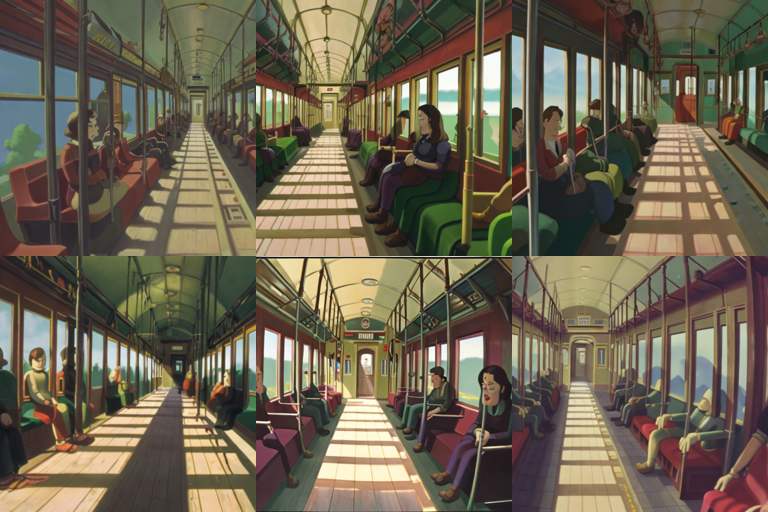

In [ ]:
image_grid(images, 2, 3)

In [ ]:
# finetune text encoder
from pathlib import Path

!accelerate launch train_dreambooth.py \
    --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1-base"  \
    --instance_data_dir="spirited_away/data" \
    --output_dir="spirited_away/spirited-away-stable-diffusion-non-inpaint" \
    --instance_prompt="a photo of sks spiritedaway" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1 \
    --train_text_encoder \
    --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


Streaming output truncated to the last 5000 lines.
diffusion_pytorch_model.safetensors:  86% 2.98G/3.46G [02:22<00:19, 24.8MB/s]





optimizer.bin:  32% 3.09G/9.65G [02:22<06:07, 17.9MB/s]


diffusion_pytorch_model.safetensors:  86% 2.98G/3.46G [02:22<00:14, 34.0MB/s]





optimizer.bin:  32% 3.09G/9.65G [02:22<04:38, 23.5MB/s]


diffusion_pytorch_model.safetensors:  86% 2.99G/3.46G [02:23<00:13, 35.0MB/s]





optimizer.bin:  32% 3.10G/9.65G [02:22<03:59, 27.3MB/s]


diffusion_pytorch_model.safetensors:  86% 2.99G/3.46G [02:23<00:17, 26.7MB/s]

diffusion_pytorch_model.safetensors:  97% 3.36G/3.46G [02:23<00:06, 17.0MB/s]





optimizer.bin:  32% 3.10G/9.65G [02:23<04:36, 23.7MB/s]


diffusion_pytorch_model.safetensors:  87% 3.00G/3.46G [02:23<00:14, 31.9MB/s]

diffusion_pytorch_model.safetensors:  97% 3.36G/3.46G [02:24<00:05, 18.9MB/s]


diffusion_pytorch_model.safetensors:  87% 3.00G/3.46G [02:23<00:13, 33.1MB/s]





optimizer.bin:  32% 3.11G/9.65G [02:23<03:54, 27.9MB/s]

diffusi

In [ ]:
device = "cuda"
model_path = "spirited_away/spirited-away-stable-diffusion-non-inpaint"

finetuned_sd = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
prompt = "POV, walkthrough, train from sks spiritedaway, masterpiece, indoor scene"

guidance_scale=7.5
num_samples = 6
generator = torch.Generator(device="cuda").manual_seed(2) # change the seed to get different results

empty_mask = Image.open("/content/drive/MyDrive/cs231n_final_project/empty_mask.png").convert("RGB")
images = finetuned_sd(
    prompt=prompt,
    image=empty_mask,
    mask_image=empty_mask, # entire image unmasked
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

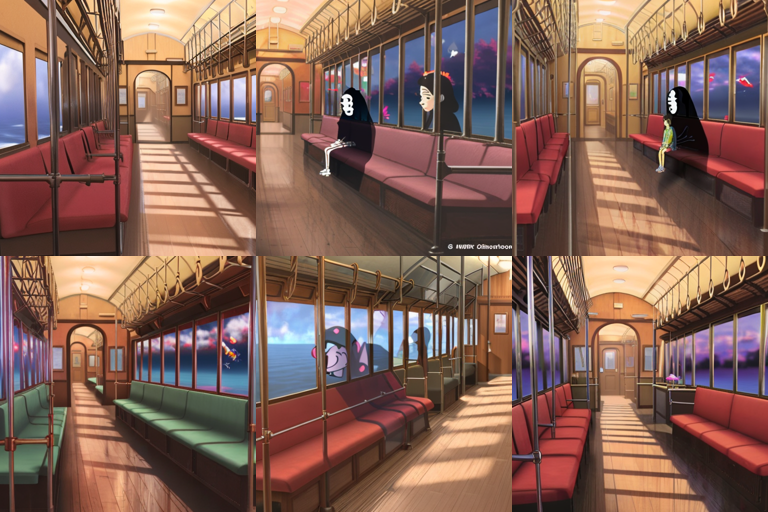

In [ ]:
image_grid(images, 2, 3)

## dreambooth on stable diffusion 2, inpaint

In [ ]:
# finetune an inpainting version too

from pathlib import Path

!accelerate launch train_dreambooth_inpaint.py \
    --train_text_encoder \
    --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-inpainting"  \
    --instance_data_dir="spirited_away/data" \
    --output_dir="spirited_away/spirited-away-stable-diffusion-inpaint" \
    --instance_prompt="a photo of sks spiritedaway" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1 \
    --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


Streaming output truncated to the last 5000 lines.

diffusion_pytorch_model.safetensors:  40% 1.37G/3.46G [01:22<01:07, 31.1MB/s]


optimizer.bin:  14% 1.39G/9.65G [01:23<05:32, 24.9MB/s]





model.safetensors: 100% 1.36G/1.36G [01:22<00:00, 23.3MB/s]

diffusion_pytorch_model.safetensors:  38% 1.31G/3.46G [01:24<02:15, 15.9MB/s]




diffusion_pytorch_model.safetensors:  40% 1.37G/3.46G [01:22<01:09, 30.0MB/s]

diffusion_pytorch_model.safetensors:  38% 1.31G/3.46G [01:24<02:03, 17.5MB/s]


optimizer.bin:  14% 1.39G/9.65G [01:23<06:43, 20.5MB/s]




model.safetensors: 100% 1.36G/1.36G [01:23<00:00, 16.4MB/s]



optimizer.bin:  14% 1.40G/9.65G [01:23<04:47, 28.7MB/s]




diffusion_pytorch_model.safetensors:  40% 1.38G/3.46G [01:22<01:07, 31.0MB/s]


optimizer.bin:  15% 1.40G/9.65G [01:23<04:16, 32.2MB/s]

diffusion_pytorch_model.safetensors:  38% 1.31G/3.46G [01:24<02:45, 13.0MB/s]




diffusion_pytorch_model.safetensors:  40% 1.39G/3.46G [01:22<00:56, 36.5MB/s]

diffusion_pytorch_model.

In [ ]:
device = "cuda"
model_path = "emily49/spirited-away-stable-diffusion-inpaint"

finetuned_sd = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/780 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
prompt = "POV, walkthrough, train from sks spiritedaway, masterpiece, indoor scene"

guidance_scale=7.5
num_samples = 6
generator = torch.Generator(device="cuda").manual_seed(2) # change the seed to get different results

empty_mask = Image.open("/content/drive/MyDrive/cs231n_final_project/empty_mask.png").convert("RGB")
images = finetuned_sd(
    prompt=prompt,
    image=empty_mask,
    mask_image=empty_mask, # entire image unmasked
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
    height=600,
    width=600,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

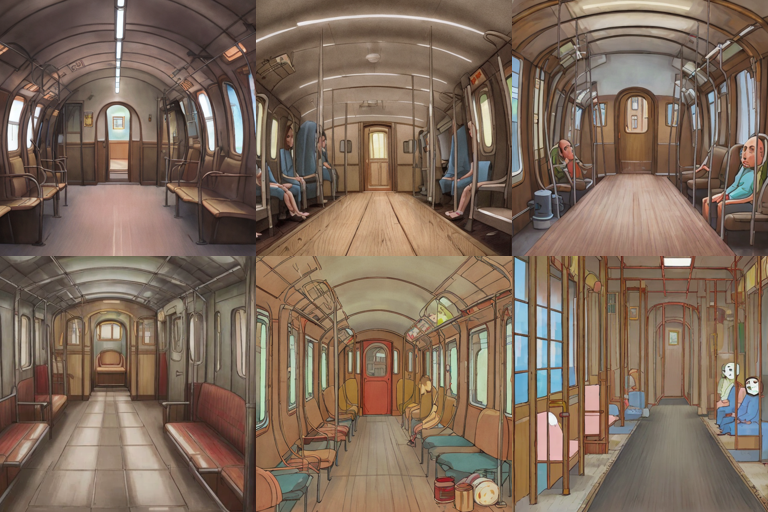

In [ ]:
image_grid(images, 2, 3)

# dreambooth on stable diffusion 1.5, non inpaint. for testing with control net

In [ ]:
# finetune text encoder too
from pathlib import Path

!accelerate launch train_dreambooth.py \
    --train_text_encoder \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
    --instance_data_dir="spirited_away/data" \
    --output_dir="spirited_away/spirited-away-stable-diffusion-non-inpaint-1-5" \
    --instance_prompt="a photo of sks spiritedaway" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1 \
    --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


Streaming output truncated to the last 5000 lines.


optimizer.bin:  23% 1.80G/7.86G [01:25<03:46, 26.7MB/s]

diffusion_pytorch_model.safetensors:  46% 1.57G/3.44G [01:25<01:15, 24.7MB/s]


diffusion_pytorch_model.safetensors:  39% 1.33G/3.44G [01:26<01:28, 23.8MB/s]

diffusion_pytorch_model.safetensors:  46% 1.58G/3.44G [01:25<00:59, 30.9MB/s]


diffusion_pytorch_model.safetensors:  39% 1.34G/3.44G [01:26<01:13, 28.5MB/s]




optimizer.bin:  23% 1.81G/7.86G [01:26<04:56, 20.4MB/s]




optimizer.bin:  23% 1.82G/7.86G [01:26<03:00, 33.5MB/s]

diffusion_pytorch_model.safetensors:  46% 1.59G/3.44G [01:25<01:17, 23.8MB/s]


diffusion_pytorch_model.safetensors:  39% 1.34G/3.44G [01:27<01:30, 23.3MB/s]

diffusion_pytorch_model.safetensors:  46% 1.59G/3.44G [01:26<01:06, 27.7MB/s]


diffusion_pytorch_model.safetensors:  39% 1.35G/3.44G [01:27<01:10, 29.7MB/s]


diffusion_pytorch_model.safetensors:  39% 1.36G/3.44G [01:27<00:59, 35.0MB/s]




optimizer.bin:  23% 1.83G/7.86G [01:27<03:58, 25.3M

# HARRY POTTER

In [ ]:
# finetune text encoder too
from pathlib import Path

!accelerate launch train_dreambooth.py \
    --train_text_encoder \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
    --instance_data_dir="harry_potter/data" \
    --output_dir="harry_potter/harry-potter-stable-diffusion-non-inpaint-1-5" \
    --instance_prompt="a photo of sks harrypotter" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1 \
    --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


Streaming output truncated to the last 5000 lines.
diffusion_pytorch_model.safetensors:  31% 1.05G/3.44G [00:52<01:09, 34.3MB/s]



optimizer.bin:  22% 1.75G/7.86G [01:16<03:43, 27.3MB/s]



optimizer.bin:  22% 1.75G/7.86G [01:16<03:36, 28.3MB/s]



optimizer.bin:  22% 1.75G/7.86G [01:16<03:13, 31.5MB/s]


diffusion_pytorch_model.safetensors:  49% 1.70G/3.44G [01:16<01:16, 22.9MB/s]


diffusion_pytorch_model.safetensors:  50% 1.70G/3.44G [01:16<01:00, 28.8MB/s]


diffusion_pytorch_model.safetensors:  50% 1.71G/3.44G [01:16<00:48, 35.7MB/s]



optimizer.bin:  22% 1.76G/7.86G [01:16<03:57, 25.7MB/s]




diffusion_pytorch_model.safetensors:  31% 1.06G/3.44G [00:52<02:32, 15.6MB/s]



optimizer.bin:  22% 1.77G/7.86G [01:16<03:03, 33.2MB/s]


diffusion_pytorch_model.safetensors:  50% 1.71G/3.44G [01:16<00:55, 31.3MB/s]




diffusion_pytorch_model.safetensors:  31% 1.06G/3.44G [00:53<02:00, 19.7MB/s]



optimizer.bin:  23% 1.77G/7.86G [01:16<02:50, 35.7MB/s]


diffusion_pytorch_model.safeten

# RATATOUILLE

In [ ]:
# finetune text encoder too
from pathlib import Path

!accelerate launch train_dreambooth.py \
    --train_text_encoder \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
    --instance_data_dir="ratatouille/data" \
    --output_dir="ratatouille/ratatouille-stable-diffusion-non-inpaint-1-5" \
    --instance_prompt="a photo of sks ratatouille" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1 \
    --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


Streaming output truncated to the last 5000 lines.
diffusion_pytorch_model.safetensors:   9% 294M/3.44G [00:23<02:57, 17.7MB/s]


model.safetensors:  56% 278M/492M [00:23<00:14, 14.8MB/s]




diffusion_pytorch_model.safetensors:   9% 297M/3.44G [00:23<02:41, 19.4MB/s]





optimizer.bin:   5% 354M/7.86G [00:23<06:37, 18.9MB/s]


model.safetensors:  57% 281M/492M [00:23<00:12, 16.5MB/s]




diffusion_pytorch_model.safetensors:   9% 302M/3.44G [00:23<02:09, 24.3MB/s]


model.safetensors:  58% 285M/492M [00:23<00:09, 21.7MB/s]





optimizer.bin:   5% 358M/7.86G [00:24<06:33, 19.1MB/s]



model.safetensors:  64% 317M/492M [00:24<00:18, 9.31MB/s]

diffusion_pytorch_model.safetensors:   8% 290M/3.44G [00:24<02:58, 17.6MB/s]





optimizer.bin:   5% 361M/7.86G [00:24<06:22, 19.6MB/s]

diffusion_pytorch_model.safetensors:   9% 294M/3.44G [00:24<02:52, 18.2MB/s]



model.safetensors:  65% 318M/492M [00:25<00:18, 9.45MB/s]





optimizer.bin:   5% 366M/7.86G [00:24<05:21, 23.3MB/s]




diffusio

# MARNIE

In [11]:
# finetune text encoder too
from pathlib import Path

!accelerate launch train_dreambooth.py \
    --train_text_encoder \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
    --instance_data_dir="marnie/data" \
    --output_dir="marnie/marnie-stable-diffusion-non-inpaint-1-5" \
    --instance_prompt="a photo of sks marnie" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1 \
    --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-06-03 20:39:57.518530: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attem

# BARBIE

In [ ]:
# finetune text encoder too
from pathlib import Path

!accelerate launch train_dreambooth.py \
    --train_text_encoder \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
    --instance_data_dir="barbie/data" \
    --output_dir="barbie/barbie-stable-diffusion-non-inpaint-1-5" \
    --instance_prompt="a photo of sks barbie" \
    --resolution=512 \
    --mixed_precision="fp16" \
    --train_batch_size=1 \
    --learning_rate=5e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=500 \
    --gradient_accumulation_steps=1 \
    --push_to_hub
    #2 ?
    # --train_text_encoder \
 # --seed="0"


Streaming output truncated to the last 5000 lines.

diffusion_pytorch_model.safetensors:  42% 1.44G/3.44G [00:58<01:27, 22.7MB/s]


diffusion_pytorch_model.safetensors:  42% 1.45G/3.44G [00:58<01:02, 31.7MB/s]

optimizer.bin:  17% 1.34G/7.86G [00:58<06:35, 16.5MB/s]





diffusion_pytorch_model.safetensors:  42% 1.44G/3.44G [00:58<01:23, 23.8MB/s]





diffusion_pytorch_model.safetensors:  42% 1.45G/3.44G [00:58<01:15, 26.5MB/s]


diffusion_pytorch_model.safetensors:  42% 1.45G/3.44G [00:59<01:00, 33.0MB/s]

optimizer.bin:  17% 1.35G/7.86G [00:58<04:48, 22.5MB/s]





diffusion_pytorch_model.safetensors:  42% 1.45G/3.44G [00:58<01:11, 27.7MB/s]

optimizer.bin:  17% 1.36G/7.86G [00:58<03:57, 27.4MB/s]





diffusion_pytorch_model.safetensors:  42% 1.45G/3.44G [00:58<00:59, 33.2MB/s]


diffusion_pytorch_model.safetensors:  42% 1.46G/3.44G [00:59<01:10, 27.9MB/s]


diffusion_pytorch_model.safetensors:  43% 1.46G/3.44G [00:59<01:07, 29.1MB/s]

optimizer.bin:  17% 1.36G/7.86G [00:59<04:56, 